In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from itertools import compress
from copy import deepcopy
from typing import List, Optional
import py3Dmol

The molecule that will define the fixed piece

In [2]:
ref_buff = """ref_ligand
                    3D
 Schrodinger Suite 2019-4.
 23 23  0  0  1  0            999 V2000
   13.8921   -2.4077   24.1269 C   0  0  0  0  0  0
   13.4897   -0.2702   23.1446 C   0  0  0  0  0  0
   12.8011    1.0351   23.3277 C   0  0  0  0  0  0
   11.6117    1.1475   24.0810 C   0  0  0  0  0  0
   10.9808    2.3973   24.2401 C   0  0  0  0  0  0
   11.5348    3.5418   23.6347 C   0  0  0  0  0  0
   12.7111    3.4432   22.8672 C   0  0  0  0  0  0
   13.3408    2.1928   22.7264 C   0  0  0  0  0  0
    9.4491    5.0959   22.7844 N   0  0  0  0  0  0
   13.2656   -1.1348   24.1544 O   0  0  0  0  0  0
   14.2110   -0.5201   22.1789 O   0  0  0  0  0  0
   11.6894    6.1877   23.4320 O   0  0  0  0  0  0
   10.1931    5.1760   25.2380 O   0  0  0  0  0  0
   10.7644    5.1384   23.8833 S   0  0  0  0  0  0
   13.5601   -3.0220   24.9622 H   0  0  0  0  0  0
   13.6512   -2.9371   23.2047 H   0  0  0  0  0  0
   14.9743   -2.3067   24.1963 H   0  0  0  0  0  0
   11.1706    0.2738   24.5305 H   0  0  0  0  0  0
   10.0785    2.4749   24.8291 H   0  0  0  0  0  0
   13.1467    4.3202   22.4103 H   0  0  0  0  0  0
   14.2657    2.1382   22.1772 H   0  0  0  0  0  0
    8.9928    6.0050   22.7148 H   0  0  0  0  0  0
    8.7689    4.3739   23.0292 H   0  0  0  0  0  0
  1 10  1  0  0  0
  1 15  1  0  0  0
  1 16  1  0  0  0
  1 17  1  0  0  0
  2  3  1  0  0  0
  2 10  1  0  0  0
  2 11  2  0  0  0
  3  4  1  0  0  0
  3  8  2  0  0  0
  4  5  2  0  0  0
  4 18  1  0  0  0
  5  6  1  0  0  0
  5 19  1  0  0  0
  6  7  2  0  0  0
  6 14  1  0  0  0
  7  8  1  0  0  0
  7 20  1  0  0  0
  8 21  1  0  0  0
  9 14  1  0  0  0
  9 22  1  0  0  0
  9 23  1  0  0  0
 12 14  2  0  0  0
 13 14  2  0  0  0
M  END
$$$
"""

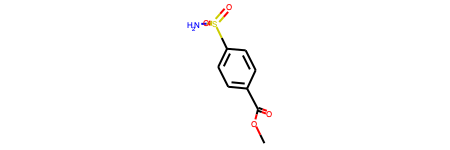

In [3]:
ref = Chem.MolFromMolBlock(ref_buff)
ref

We want to generate conformers for this molecule with ref fixed

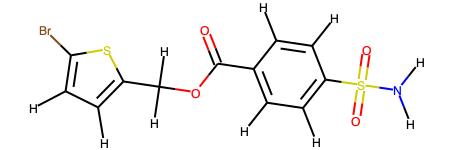

In [4]:
smiles = "NS(=O)(=O)c1ccc(C(=O)OCc2ccc(Br)s2)cc1"
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)
mol

A simple function to generate conformers with a constrained piece and align the resulting conformers to the reference. 

In [5]:
def duplicate_conformers(m: Chem.rdchem.Mol, new_conf_idx: int, rms_limit: float = 0.5) -> bool:
    rmslist = []
    for i in range(m.GetNumConformers()):
        if i == new_conf_idx:
            continue
        rms = AllChem.GetConformerRMS(m, new_conf_idx, i, prealigned=True)
        rmslist.append(rms)
    return any(i < rms_limit for i in rmslist)


def get_mcs(mol_one: Chem.rdchem.Mol, mol_two: Chem.rdchem.Mol) -> str:
    """Code to find the maximum common substructure between two molecules."""
    return Chem.MolToSmiles(
        Chem.MolFromSmarts(
            rdFMCS.FindMCS([mol_one,mol_two], completeRingsOnly=True, matchValences=True).smartsString
        )
    )


def generate_conformers(mol: Chem.rdchem.Mol,
                        ref_mol: Chem.rdchem.Mol,
                        num_conf: int,
                        ref_smi: str = None,
                        minimum_conf_rms: Optional[float] = None,
                       ) -> List[Chem.rdchem.Mol]:

    # if SMILES to be fixed are not given, assume to the MCS
    if not ref_smi:
        ref_smi = get_mcs(mol, ref_mol)

    # Creating core of reference ligand #
    core_with_wildcards = AllChem.ReplaceSidechains(ref_mol, Chem.MolFromSmiles(ref_smi))
    core = AllChem.DeleteSubstructs(core_with_wildcards, Chem.MolFromSmiles('*'))
    core.UpdatePropertyCache()

    # Add Hs so that conf gen is improved
    mol.RemoveAllConformers()
    mol = Chem.AddHs(mol)

    # Generate conformers with constrained embed
    dup_count = 0
    for i in range(num_conf):
        temp_mol = AllChem.ConstrainedEmbed(deepcopy(mol), core, randomseed=i)
        conf_idx = mol.AddConformer(temp_mol.GetConformer(0), assignId=True)
        if minimum_conf_rms is not None:
            if duplicate_conformers(mol, conf_idx, rms_limit=minimum_conf_rms):
                dup_count += 1
                mol.RemoveConformer(conf_idx)
    if dup_count:
        print(f'removed {dup_count} duplicated conformations')
    return Chem.RemoveHs(mol)

mol = generate_conformers(mol, ref, 80, minimum_conf_rms=0.5)
print(mol.GetNumConformers())

removed 55 duplicated conformations
25


In [6]:
# visualise confs
view = py3Dmol.view()
for i in range(mol.GetNumConformers()):
    mb = Chem.MolToMolBlock(mol, confId=i)
    view.addModel(mb, 'sdf')
view.setStyle({'stick': {}})
view.setBackgroundColor('0xeeeeee')
view.zoomTo()
view

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Filter conformations that clash with the protein

In [7]:
# This class is a hybrid between biopython and rdkit. (They both use arrays for atom coords)
import Bio.PDB as PDB

class ProteinLigandClashFilter:
    def __init__(self, protein_pdbpath: str, distance: float = 1.5):
        parser = PDB.PDBParser(QUIET=True, PERMISSIVE=True)
        s = parser.get_structure('protein', protein_pdbpath)
        self.kd = PDB.NeighborSearch(list(s.get_atoms()))
        self.radius = distance

    def __call__(self, conf: Chem.rdchem.Conformer) -> bool:
        for coord in conf.GetPositions():
            res = self.kd.search(coord, radius=self.radius)
            if len(res):
                return True
        return False

In [8]:
# initialise using a protein pdb file with ligands and unwanted waters removed
pdb_path = '/path/to/protein.pdb'
pdb_path = '/Users/jmeyers/Desktop/5r7y_protein.pdb'
clash_filter = ProteinLigandClashFilter(pdb_path, distance=0.5)

In [9]:
# generate a mask and filter clashing confs from list
for conf in mol.GetConformers():
    if clash_filter(conf):
        confid = conf.GetId()
        print(f'removing conformer id: {confid}')
        mol.RemoveConformer(confid)
print(mol.GetNumConformers(), 'conformers remaining')

removing conformer id: 2
removing conformer id: 14
removing conformer id: 15
removing conformer id: 16
removing conformer id: 18
20 conformers remaining


In [10]:
# load PDB with waters and ligand deleted (kept single structural water)
pdb = Chem.MolFromPDBFile(pdb_path)

chA = {'chain':'A'}
view = py3Dmol.view()
view.addModel(Chem.MolToPDBBlock(pdb), 'pdb')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, chA)

n = -1
for n, conf in enumerate(mol.GetConformers()):
    mb = Chem.MolToMolBlock(mol, confId=conf.GetId())
    view.addModel(mb, 'sdf')
    view.setStyle({'model': n+1}, {'stick': {}})

view.setBackgroundColor('0xeeeeee')
view.zoomTo({'model': n+1})
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

- On second thoughts. It would be more efficient to remove duplicate conformers after filtering for clashes with the protein. Not this way round!